In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import os

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

import librosa
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:


dataset_path = "SpeechCommands/speech_commands_v0.02"

target_file = "right"

train_set = []
test_set = []

negative_files = [f for f in os.listdir(dataset_path) if not os.path.isfile(os.path.join(dataset_path, f)) and f!='_background_noise_' and f!=target_file]

print(len(train_set))

target_file_path = dataset_path +"/"+target_file

total_size = len(os.listdir(target_file_path))

count = 0

for file_path in os.listdir(target_file_path):
    file_name = target_file_path+"/" + file_path
    audio, sample_rate = torchaudio.load(file_name)
    if count < total_size*0.75:
        train_set.append([audio,sample_rate,file_name,1]) ## wake word
    else:
        test_set.append([audio,sample_rate,file_name,1])
    count +=1


## sampling other wake words as negative examples
for _ in range(len(train_set)):
    folder = dataset_path+"/"+np.random.choice(negative_files)
    file =folder+ "/"+ np.random.choice(os.listdir(folder))
    audio, sample_rate = torchaudio.load(file)
    train_set.append([audio,sample_rate,file,0])

for _ in range(len(test_set)):
    folder = dataset_path+"/"+np.random.choice(negative_files)
    file =folder+ "/"+ np.random.choice(os.listdir(folder))
    audio, sample_rate = torchaudio.load(file)
    test_set.append([audio,sample_rate,file,0])




0


In [3]:

index = np.random.randint(len(train_set))
print(f"index:{index}")
print(train_set[index])
print(train_set[index][0].shape)

display(ipd.Audio(train_set[index][0].numpy(), rate=train_set[index][1]))

print(len(test_set))

index:1997
[tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 16000, 'SpeechCommands/speech_commands_v0.02/right/8a28231e_nohash_2.wav', 1]
torch.Size([1, 16000])


1888


index:3005
tensor([[-6.1035e-05, -6.1035e-05, -1.2207e-04,  ...,  1.8311e-04,
          1.2207e-04,  9.1553e-05]])
[tensor([[-6.1035e-05, -6.1035e-05, -1.2207e-04,  ...,  1.8311e-04,
          1.2207e-04,  9.1553e-05]]), tensor([[0.0035, 0.0078, 0.0072,  ..., 0.0173, 0.0148, 0.0141]]), tensor([[9.1553e-05, 6.1035e-05, 6.1035e-05,  ..., 9.1553e-05, 2.1362e-04,
         1.2207e-04]]), tensor([[-0.0009, -0.0015, -0.0002,  ..., -0.0003, -0.0005, -0.0013]]), tensor([[0.0011, 0.0021, 0.0026,  ..., 0.0044, 0.0037, 0.0031]]), tensor([[0.0002, 0.0005, 0.0004,  ..., 0.0005, 0.0007, 0.0006]]), tensor([[ 0.0018, -0.0028, -0.0052,  ...,  0.0079,  0.0059,  0.0120]]), tensor([[ 3.0518e-05,  1.5259e-04, -3.0518e-05,  ..., -1.5259e-04,
         -1.2207e-04, -6.1035e-05]]), tensor([[-0.0002, -0.0004, -0.0006,  ...,  0.0003,  0.0003,  0.0004]]), tensor([[0.0004, 0.0005, 0.0003,  ..., 0.0008, 0.0006, 0.0005]])]
torch.Size([10, 16000])


xxx: [-6.1035156e-05 -6.1035156e-05 -1.2207031e-04 ...  1.8310547e-04
  1.2207031e-04  9.1552734e-05]


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


[[-6.28318420e+02 -6.19258545e+02 -6.17440735e+02 ... -6.06311218e+02
  -6.06411987e+02 -6.14392212e+02]
 [ 2.11125064e+00  9.54990959e+00  1.05142603e+01 ...  1.85340538e+01
   1.94832191e+01  1.42000675e+01]
 [ 1.01669788e-01 -2.02609348e+00 -4.47033405e+00 ... -8.25960827e+00
  -5.84134007e+00 -1.67361820e+00]
 ...
 [-1.63422477e+00 -5.19257069e+00 -4.36808491e+00 ... -4.62541771e+00
  -4.04390001e+00 -3.59976983e+00]
 [-1.51437104e+00 -3.77531838e+00 -3.52124405e+00 ... -3.28160548e+00
  -1.60103512e+00 -4.66376019e+00]
 [-4.89369243e-01  1.74658537e-01 -9.40099597e-01 ... -2.65467674e-01
  -8.13065767e-01 -3.29214525e+00]]
Shape of mfcc: (40, 32)


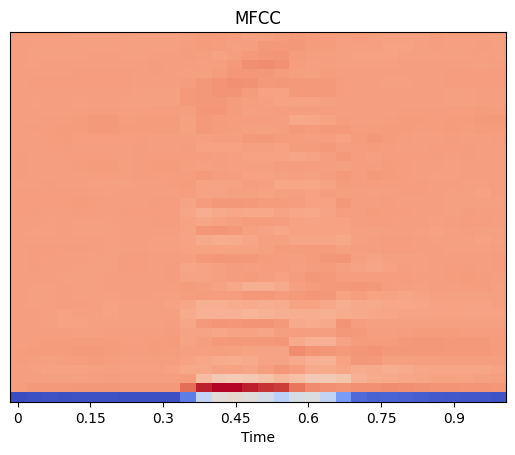

[[-6.28318420e+02 -6.19258545e+02 -6.17440735e+02 ... -6.06311218e+02
  -6.06411987e+02 -6.14392212e+02]
 [ 2.11125064e+00  9.54990959e+00  1.05142603e+01 ...  1.85340538e+01
   1.94832191e+01  1.42000675e+01]
 [ 1.01669788e-01 -2.02609348e+00 -4.47033405e+00 ... -8.25960827e+00
  -5.84134007e+00 -1.67361820e+00]
 ...
 [-1.63422477e+00 -5.19257069e+00 -4.36808491e+00 ... -4.62541771e+00
  -4.04390001e+00 -3.59976983e+00]
 [-1.51437104e+00 -3.77531838e+00 -3.52124405e+00 ... -3.28160548e+00
  -1.60103512e+00 -4.66376019e+00]
 [-4.89369243e-01  1.74658537e-01 -9.40099597e-01 ... -2.65467674e-01
  -8.13065767e-01 -3.29214525e+00]]
(40, 32)
<class 'numpy.ndarray'>


In [4]:
index = np.random.randint(len(train_set))
print(f"index:{index}")
print(train_set[index][0])
print([train_set[index+i][0] for i in range(10)])

aaa = torch.stack([train_set[index][0] for i in range(10)]).squeeze()
print(aaa.shape)

display(ipd.Audio(train_set[index][0].numpy(), rate=16000))

transform = torchaudio.transforms.MFCC(sample_rate=16000)
# mfcc = transform(train_set[index][0])
# mfcc = transform(aaa.squeeze())
xxx = train_set[index][0][0].numpy()
print(f"xxx: {train_set[index][0][0].numpy()}")

mfcc = librosa.feature.mfcc(y=xxx, sr=16000,n_mfcc=40)

print(mfcc)

print("Shape of mfcc:", mfcc.shape)
plt.title("MFCC")
# librosa.display.specshow(mfcc.numpy()[0], sr=16000, x_axis='time')
librosa.display.specshow(mfcc, sr=16000, x_axis='time')
plt.show()
print(mfcc)
print(mfcc.shape)
print(type(mfcc))

In [5]:
class myLSTM(nn.Module):

    def __init__(self, mfcc_size, hidden_dim, output_size):
        super(myLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.normLayer = nn.LayerNorm(mfcc_size)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(mfcc_size, hidden_dim,batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, 128),
        #     nn.LeakyReLU(),
        #     nn.Dropout(0.5),
        #     nn.Linear(128, 64),
        #     nn.LeakyReLU(),
        #     nn.Linear(64,1)
        # )

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.activation =  nn.LeakyReLU()
        self.linear2 = nn.Linear(hidden_dim,output_size)
        self.sig  = nn.Sigmoid()

    def forward(self, mfcc):
        mfcc = mfcc.transpose(1,2) ## change from 40*81 to 81*40
        mfcc = self.normLayer(mfcc)
        lstm_out, (hidden_last,cell_last)= self.lstm(mfcc) ## batch size* number of mfcc * mfcc feature size
        output = self.linear2(self.activation(self.linear(hidden_last)))
        # output = self.linear2(hidden_last)
        # output = self.classifier(hidden_last)
        output = self.sig(output)
        # print(f"hello:{output.shape}")
        # output = F.softmax(output, dim=2)
        return output
    
model = myLSTM(mfcc_size=40,hidden_dim=40,output_size=1)
model.to(device)

myLSTM(
  (normLayer): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
  (lstm): LSTM(40, 40, batch_first=True)
  (linear): Linear(in_features=40, out_features=40, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=40, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [6]:
# x = torch.randn(50, 81,40)
# lin = nn.Linear(40, 2)
# out = lin(x)
# print(out.shape)
# print(out.transpose(1,2).shape)
# x = torch.tensor([[[1,2,3,4],[2,4,6,8],[3,6,9,12]],[[10,20,30,40],[20,40,60,80],[3,6,9,12]]]).float()
# print(x.shape)
# out_prob = F.log_softmax(x,dim=2)
# print(out_prob.shape)
# print(out)

In [7]:
# #input is of size N x C = 3 x 5
# input = torch.randn(3, 5, requires_grad=True)
# # each element in target has to have 0 <= value < C
# target = torch.tensor([1, 0, 4])
# output = F.nll_loss(F.log_softmax(input, dim=1), target)
# print(output)
# output.backward()

In [8]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.001)
    # print(batch.shape)
    # batch = batch.permute(0, 2, 1)
    transform = torchaudio.transforms.MFCC(sample_rate=16000)
    mfcc = transform(batch)
    return mfcc

def collate_fn(batch):

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, sample_rate, file_path ,label in batch:
        
        # transform = torchaudio.transforms.MFCC(sample_rate=16000)
        # mfcc = transform(waveform)
        
        tensors += [waveform.squeeze()] ## 1x40x81 to 40x81
        targets += [torch.tensor(label).float()]
        # print(tensors)
        # print(targets)

    # Group the list of tensors into a batched tensor
    # print("hello")
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False


train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [9]:
train_features,train_labels = next(iter(train_loader))
print(train_features.shape)
print(train_labels.shape)
# train_features = train_features.to(device)
# print(f"shape: {model(train_features.squeeze(0)).shape}")
# print("test")
# print(model(train_features))


torch.Size([256, 40, 81])
torch.Size([256])


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        # data = transform(data)
        output = model(data)
        # print(f"output:{output.squeeze(0,2)}")
        # print(f"target:{target}")

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        # loss = F.nll_loss(output.squeeze(), target)
        # loss = nn.BCEWithLogitsLoss()(output.squeeze(0,2), target)
        loss = F.cross_entropy(output.squeeze(0,2), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # # update progress bar
        # pbar.update(pbar_update)
        # # record loss
        # losses.append(loss.item())


In [12]:

train(model,10,20)

/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 10 [0/5668 (0%)]	Loss: 687.654968
Train Epoch: 10 [5120/5668 (87%)]	Loss: 753.995850


In [13]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    acc = rounded_preds.eq(y.view_as(rounded_preds)).sum().item() / len(y)
    return acc


from sklearn.metrics import classification_report

def test(test_loader, model, device, epoch):
    print("\n starting test for epoch %s"%epoch)
    accs = []
    preds = []
    labels = []
    with torch.no_grad():
        for idx, (mfcc, label) in enumerate(test_loader):
            mfcc, label = mfcc.to(device), label.to(device)
            output = model(mfcc)
            # pred = torch.sigmoid(output)
            acc = binary_accuracy(output, label)
            preds += torch.flatten(torch.round(output)).cpu()
            labels += torch.flatten(label).cpu()
            accs.append(acc)
            print("Iter: {}/{}, accuracy: {}".format(idx, len(test_loader), acc), end="\r")
    average_acc = sum(accs)/len(accs) 
    print('Average test Accuracy:', average_acc, "\n")
    report = classification_report(labels, preds)
    print(report)
    return average_acc, report
    # return average_acc


# def test(model, epoch):
#     model.eval()
#     correct = 0
#     for data, target in test_loader:

#         data = data.to(device)
#         target = target.to(device)
#         # print(f"test target:{target}")

#         # apply transform and model on whole batch directly on device
#         # data = transform(data)
#         output = model(data)
#         # print(f"test output:{output}")

#         pred = get_likely_index(output)
#         correct += number_of_correct(pred, target)

#         # update progress bar
#         pbar.update(pbar_update)

#     print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [17]:
log_interval = 20
n_epoch = 20

for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    test(test_loader, model, device,epoch)

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

Train Epoch: 1 [0/5668 (0%)]	Loss: 636.899353
Train Epoch: 1 [5120/5668 (87%)]	Loss: 669.441589

 starting test for epoch 1
Average test Accuracy: 0.91015625 

              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91       944
         1.0       0.94      0.86      0.90       944

    accuracy                           0.91      1888
   macro avg       0.91      0.91      0.91      1888
weighted avg       0.91      0.91      0.91      1888

Train Epoch: 2 [0/5668 (0%)]	Loss: 665.148254


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 2 [5120/5668 (87%)]	Loss: 673.474487

 starting test for epoch 2
Average test Accuracy: 0.8916015625 

              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89       944
         1.0       0.96      0.80      0.87       944

    accuracy                           0.89      1888
   macro avg       0.90      0.89      0.88      1888
weighted avg       0.90      0.89      0.88      1888

Train Epoch: 3 [0/5668 (0%)]	Loss: 603.898254


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 3 [5120/5668 (87%)]	Loss: 673.296021

 starting test for epoch 3
Average test Accuracy: 0.9091796875 

              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       944
         1.0       0.92      0.89      0.91       944

    accuracy                           0.91      1888
   macro avg       0.91      0.91      0.91      1888
weighted avg       0.91      0.91      0.91      1888

Train Epoch: 4 [0/5668 (0%)]	Loss: 729.718201


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 4 [5120/5668 (87%)]	Loss: 689.934082

 starting test for epoch 4
Average test Accuracy: 0.8834635416666666 

              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88       944
         1.0       0.86      0.93      0.89       944

    accuracy                           0.89      1888
   macro avg       0.89      0.89      0.89      1888
weighted avg       0.89      0.89      0.89      1888

Train Epoch: 5 [0/5668 (0%)]	Loss: 649.256348


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 5 [5120/5668 (87%)]	Loss: 652.874634

 starting test for epoch 5
Average test Accuracy: 0.9041341145833334 

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90       944
         1.0       0.92      0.89      0.90       944

    accuracy                           0.90      1888
   macro avg       0.90      0.90      0.90      1888
weighted avg       0.90      0.90      0.90      1888

Train Epoch: 6 [0/5668 (0%)]	Loss: 704.921814


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 6 [5120/5668 (87%)]	Loss: 690.042480

 starting test for epoch 6
Average test Accuracy: 0.9148763020833334 

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       944
         1.0       0.93      0.89      0.91       944

    accuracy                           0.91      1888
   macro avg       0.91      0.91      0.91      1888
weighted avg       0.91      0.91      0.91      1888

Train Epoch: 7 [0/5668 (0%)]	Loss: 641.896057


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 7 [5120/5668 (87%)]	Loss: 749.472107

 starting test for epoch 7
Average test Accuracy: 0.9261067708333334 

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       944
         1.0       0.94      0.91      0.92       944

    accuracy                           0.92      1888
   macro avg       0.92      0.92      0.92      1888
weighted avg       0.92      0.92      0.92      1888

Train Epoch: 8 [0/5668 (0%)]	Loss: 594.679321


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 8 [5120/5668 (87%)]	Loss: 605.443298

 starting test for epoch 8
Average test Accuracy: 0.91943359375 

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       944
         1.0       0.93      0.89      0.91       944

    accuracy                           0.92      1888
   macro avg       0.92      0.92      0.92      1888
weighted avg       0.92      0.92      0.92      1888

Train Epoch: 9 [0/5668 (0%)]	Loss: 669.742737


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 9 [5120/5668 (87%)]	Loss: 678.504395

 starting test for epoch 9
Average test Accuracy: 0.9226888020833334 

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       944
         1.0       0.93      0.92      0.92       944

    accuracy                           0.92      1888
   macro avg       0.92      0.92      0.92      1888
weighted avg       0.92      0.92      0.92      1888

Train Epoch: 10 [0/5668 (0%)]	Loss: 639.339600


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 10 [5120/5668 (87%)]	Loss: 716.621216

 starting test for epoch 10
Average test Accuracy: 0.921875 

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       944
         1.0       0.90      0.94      0.92       944

    accuracy                           0.92      1888
   macro avg       0.92      0.92      0.92      1888
weighted avg       0.92      0.92      0.92      1888

Train Epoch: 11 [0/5668 (0%)]	Loss: 662.504761


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 11 [5120/5668 (87%)]	Loss: 670.022217

 starting test for epoch 11
Average test Accuracy: 0.9244791666666666 

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       944
         1.0       0.93      0.91      0.92       944

    accuracy                           0.92      1888
   macro avg       0.92      0.92      0.92      1888
weighted avg       0.92      0.92      0.92      1888

Train Epoch: 12 [0/5668 (0%)]	Loss: 680.232178


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 12 [5120/5668 (87%)]	Loss: 715.785461

 starting test for epoch 12
Average test Accuracy: 0.9309895833333334 

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       944
         1.0       0.94      0.91      0.93       944

    accuracy                           0.93      1888
   macro avg       0.93      0.93      0.93      1888
weighted avg       0.93      0.93      0.93      1888

Train Epoch: 13 [0/5668 (0%)]	Loss: 637.901978


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 13 [5120/5668 (87%)]	Loss: 660.658447

 starting test for epoch 13
Average test Accuracy: 0.9314778645833334 

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       944
         1.0       0.94      0.91      0.93       944

    accuracy                           0.93      1888
   macro avg       0.93      0.93      0.93      1888
weighted avg       0.93      0.93      0.93      1888

Train Epoch: 14 [0/5668 (0%)]	Loss: 652.877075


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 14 [5120/5668 (87%)]	Loss: 642.168091

 starting test for epoch 14
Average test Accuracy: 0.9244791666666666 

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       944
         1.0       0.93      0.91      0.92       944

    accuracy                           0.92      1888
   macro avg       0.92      0.92      0.92      1888
weighted avg       0.92      0.92      0.92      1888

Train Epoch: 15 [0/5668 (0%)]	Loss: 611.707214


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 15 [5120/5668 (87%)]	Loss: 705.853027

 starting test for epoch 15
Average test Accuracy: 0.9300130208333334 

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       944
         1.0       0.94      0.91      0.93       944

    accuracy                           0.93      1888
   macro avg       0.93      0.93      0.93      1888
weighted avg       0.93      0.93      0.93      1888

Train Epoch: 16 [0/5668 (0%)]	Loss: 662.988892


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 16 [5120/5668 (87%)]	Loss: 688.138184

 starting test for epoch 16
Average test Accuracy: 0.9296875 

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       944
         1.0       0.93      0.93      0.93       944

    accuracy                           0.93      1888
   macro avg       0.93      0.93      0.93      1888
weighted avg       0.93      0.93      0.93      1888

Train Epoch: 17 [0/5668 (0%)]	Loss: 703.881104


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 17 [5120/5668 (87%)]	Loss: 671.641724

 starting test for epoch 17
Average test Accuracy: 0.9345703125 

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       944
         1.0       0.94      0.92      0.93       944

    accuracy                           0.93      1888
   macro avg       0.93      0.93      0.93      1888
weighted avg       0.93      0.93      0.93      1888

Train Epoch: 18 [0/5668 (0%)]	Loss: 730.910400


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 18 [5120/5668 (87%)]	Loss: 650.892944

 starting test for epoch 18
Average test Accuracy: 0.9322916666666666 

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       944
         1.0       0.92      0.94      0.93       944

    accuracy                           0.93      1888
   macro avg       0.93      0.93      0.93      1888
weighted avg       0.93      0.93      0.93      1888

Train Epoch: 19 [0/5668 (0%)]	Loss: 669.365417


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 19 [5120/5668 (87%)]	Loss: 686.096741

 starting test for epoch 19
Average test Accuracy: 0.9319661458333334 

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       944
         1.0       0.96      0.90      0.93       944

    accuracy                           0.93      1888
   macro avg       0.93      0.93      0.93      1888
weighted avg       0.93      0.93      0.93      1888

Train Epoch: 20 [0/5668 (0%)]	Loss: 687.530762


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 20 [5120/5668 (87%)]	Loss: 645.813232

 starting test for epoch 20
Average test Accuracy: 0.93408203125 

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       944
         1.0       0.96      0.90      0.93       944

    accuracy                           0.93      1888
   macro avg       0.93      0.93      0.93      1888
weighted avg       0.93      0.93      0.93      1888



In [15]:
index = np.random.randint(len(test_set))
print(f"index:{index}")
print(test_set[index])

display(ipd.Audio(test_set[index][0].numpy(), rate=16000))
audio = test_set[index][0]
transform = torchaudio.transforms.MFCC(sample_rate=16000)
mfcc = transform(audio).to(device)
# print(mfcc)
prediction = model(mfcc)
print(prediction)

index:1026
[tensor([[0.0003, 0.0003, 0.0001,  ..., 0.0008, 0.0008, 0.0008]]), 16000, 'SpeechCommands/speech_commands_v0.02/bird/2aca1e72_nohash_0.wav', 0]


tensor([[[0.0213]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [18]:
######## IMPORTS ##########
import sounddevice as sd
from scipy.io.wavfile import write
import librosa
import numpy as np

####### ALL CONSTANTS #####
fs = 16000
seconds = 2
filename = "prediction.wav"
class_names = ["Wake Word NOT Detected", "Wake Word Detected"]

##### LOADING OUR SAVED MODEL and PREDICTING ###
# model = load_model("saved_model/WWD2.h5")

print("Prediction Started: ")
while True:
    print("Say Now: ")
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
    sd.wait()
    # print(f"myrecording:{myrecording}")
    write(filename, fs, myrecording)

    audio, sample_rate = torchaudio.load(filename)

    transform = torchaudio.transforms.MFCC(sample_rate=16000)
    mfcc = transform(audio).to(device)

    model.eval()
    
    prediction = model(mfcc)
    prediction = prediction.squeeze().to("cpu").detach().numpy()

    if prediction > 0.5:
        print(f"Wake Word Detected for {target_file},{prediction}")
    else:
        print(f"No word,{prediction}")
    


Prediction Started: 
Say Now: 


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


No word,3.1859779259235665e-09
Say Now: 
No word,7.68241170590045e-06
Say Now: 
Wake Word Detected for right,0.9982032775878906
Say Now: 
No word,1.9192718809790676e-06
Say Now: 
No word,1.617683764720823e-11
Say Now: 
No word,1.0892384125327226e-05
Say Now: 
No word,0.0008470515022054315
Say Now: 
Wake Word Detected for right,0.5770568251609802
Say Now: 
No word,1.9180513390892884e-06
Say Now: 
No word,2.3516874211870764e-11
Say Now: 
No word,6.837447472207714e-06
Say Now: 
Wake Word Detected for right,0.9996261596679688
Say Now: 
No word,1.87357017011891e-07
Say Now: 
No word,2.605490129203858e-11
Say Now: 
No word,2.9033501505182358e-06
Say Now: 
No word,1.5901558469977317e-07
Say Now: 
Wake Word Detected for right,0.9992508292198181
Say Now: 
No word,8.722123311599717e-06
Say Now: 
No word,0.00014741391350980848
Say Now: 
No word,0.003830201691016555
Say Now: 
Wake Word Detected for right,0.9627403616905212
Say Now: 
No word,5.434151045813351e-11
Say Now: 
No word,7.861160056243932

KeyboardInterrupt: 